<a href="https://colab.research.google.com/github/GeorgeSherif/ChatEGP/blob/main/Translate_Ar_En.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [36]:
!pip3 install transformers sentencepiece nltk protobuf torch pygal simpletransformers torchvision


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import os
import warnings
import csv
from textblob import TextBlob
import re
from nltk.stem.isri import ISRIStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 
from textblob import TextBlob

import torch
import torchvision

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [40]:
df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
df['Sentiment'] = df['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
df

,Sentiment,Sentence
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


<Axes: xlabel='count', ylabel='Sentiment'>

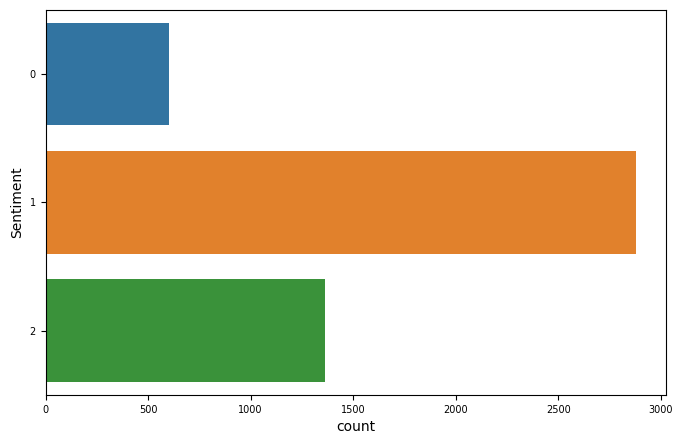

In [41]:
sns.countplot(y="Sentiment",data=df)

In [42]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


### Determinig the sentiment using TextBlob Polarity

In [43]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', '')
    ReviewText = ReviewText.str.replace(',', '')
    ReviewText = ReviewText.str.replace('--', '')    
    ReviewText = ReviewText.str.replace('`', '')    

    return ReviewText
df['Review Text'] = preprocess(df['Sentence'])

df['polarity'] = df['Sentence'].map(lambda text: TextBlob(text).sentiment.polarity)
df['sentence_len'] = df['Review Text'].astype(str).apply(len)
df['word_count'] = df['Sentence'].apply(lambda x: len(str(x).split()))

In [44]:
df = df.drop(["sentence_len", "Sentence","word_count","polarity" ] , axis =1)


### Sentiment Analysis using BERT

In [45]:
from sklearn.model_selection import train_test_split
X_features = df["Review Text"]
Y_features = df["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Sentiment.values, test_size=0.2, random_state=42, shuffle=True)

In [46]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [47]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby([ 'Sentiment', 'data_type']).count()
df = df.rename(columns={'Review Text': 'Sentence'})


In [48]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 80,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus( df[df.data_type == 'val'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 80,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [49]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Sentiment.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].Sentiment.values)
     

In [50]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [51]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 8) #since we don't have to do backpropagation for this step

In [52]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-7) #2e-5 > 5e-5
                 
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps =len(dataloader_train)*epochs)


In [53]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [54]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [55]:
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')

In [56]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [57]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLP/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/3 [1:05:34<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



 33%|███▎      | 1/3 [1:10:30<2:21:00, 4230.26s/it]

Validation loss: 0.4377836395393718
F1 Score (weighted): 0.8233462030823877



 33%|███▎      | 1/3 [2:14:50<2:21:00, 4230.26s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 67%|██████▋   | 2/3 [2:19:49<1:09:48, 4188.36s/it]

Validation loss: 0.4858403139832345
F1 Score (weighted): 0.8390961072277918



 67%|██████▋   | 2/3 [3:24:06<1:09:48, 4188.36s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



100%|██████████| 3/3 [3:29:02<00:00, 4180.69s/it]

Validation loss: 0.5151993139369859
F1 Score (weighted): 0.8548481511857235


In [58]:
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 121/121 [04:52<00:00,  2.41s/it]


In [59]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:104/120
 -> 0.8666666666666667
Accuracy:503/575
 -> 0.8747826086956522
Accuracy:220/273
 -> 0.8058608058608059


In [60]:
path = F"/content/gdrive/MyDrive/NLP/BERT_ft_epoch3.model"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [61]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [62]:
# preprocess the sentence
sentence = "The Emirates Financial Market Index increased during yesterday’s session by 1.44% to close at 12.2663 points, and the market value increased by 50.5 billion dirhams to reach 67.386 billion dirhams. 0.85 billion shares, with a total value of 1.32 billion dirhams, through 14,654 transactions."
input_ids = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)).unsqueeze(0)
attention_mask = torch.tensor([1] * input_ids.shape[1]).unsqueeze(0)

# get the predicted sentiment label
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, predicted_label = torch.max(outputs[0], dim=1)


In [63]:
predicted_label

tensor([2])

# End


In [64]:
model.summary()


AttributeError: ignored

In [ ]:
from simpletransformers.classification import ClassificationModel


# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)

In [ ]:
# 0,1,2 : positive,negative
def making_label(st):
    if(st=='positive'):
        return 0
    elif(st=='neutral'):
        return 2
    else:
        return 1
    
train['label'] = train['Sentiment'].apply(making_label)
test['label'] = test['Sentiment'].apply(making_label)
print(train.shape)

In [ ]:
train_df = pd.DataFrame({
    'text': train['Sentence'][:1500].replace(r'\n', ' ', regex=True),
    'label': train['label'][:1500]
})

eval_df = pd.DataFrame({
    'text': test['Sentence'][-400:].replace(r'\n', ' ', regex=True),
    'label': test['label'][-400:]
})

In [ ]:
model.train_model(train_df)

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [ ]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [ ]:
true = eval_df['label'].tolist()
predicted = lst

In [ ]:
import sklearn
sklearn.metrics.accuracy_score(true,predicted)

In [ ]:
predictions, raw_outputs = model.predict("Almost all the region's markets reversed in yesterday's session trading from the trend they were in the previous session in light of the dominance of buying operations in the markets throughout the trading period almost with the encouragement of some dealers to take financial positions on selected shares for the purpose of investment or speculation after the prices became more attractive and in Under the return of relative stability to the regional and global climate. Where only the Jordanian market declined under pressure from the services stocks, as it declined by 0.27%, to close its general index at the level of 2350.91 points. The Kuwaiti market bounced back to recover most of the losses of the previous session, supported by almost all sectors, amid a decline in liquidity, as it rose by 0.66%, to close at 6914.40 points. The Saudi stock market maintained its upward trend, with the support of the main sectors and stocks in the market, as it rose by 0.36%, to close at 43.6332 points. Buying forces returned to control the Qatari Stock Exchange to recoup most of the losses of the previous session, rising by 0.59% to close at 81158.87 points. With the rebound of heavy stocks in the Bahraini market from the levels of the previous session, the Bahraini market recovered all the losses, to close its index at 1438.87 points, with a gain of 0.83%. The Omani market continued its rise, supported by a number of its best stocks, as it rose by 0.31%, to close at 6602.95 points.")

In [ ]:
np.average(predictions)

### Uploading the MarianMTModel Translator

In [ ]:
from transformers import MarianTokenizer, MarianMTModel
mname = "marefa-nlp/marefa-mt-en-ar"
tokenizer = MarianTokenizer.from_pretrained(mname)
model = MarianMTModel.from_pretrained(mname)

### Translating the dataset

In [ ]:
# English Text
input = "With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability."

translated_tokens = model.generate(**tokenizer.prepare_seq2seq_batch([input], return_tensors="pt"))
translated_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated_tokens]

# translated Arabic Text
print(translated_text)


In [ ]:
# Directory containing the text files to merge
dir_path = 'gdrive/My Drive/Finance/'

# List of all the text files in the directory
files = os.listdir(dir_path)
print(files)

# Open the CSV file for writing
with open('merged_file.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row to the CSV file
    writer.writerow(['filename', 'content'])

    # Iterate through all the text files in the directory
    for file in files:
        if file.endswith('.txt'):
            # Open the text file for reading
            with open(os.path.join(dir_path, file), 'r') as f:
                content = f.read()
                
            # Write the filename and content to the CSV file
            writer.writerow([file, content])

# Close the CSV file
csvfile.close()

In [ ]:
df = pd.read_csv("merged_file.csv")
print(df.describe)